In [175]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset|
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from MountainDataset import MountainDataset
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.is_available())
DEVICE

True


'cuda'

In [176]:
SEED = 12345
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [187]:
def iou_coef(y_true, y_pred):
    intersection = torch.sum(torch.abs(y_true * y_pred), [1,2,3])
    union = torch.sum(y_true,[1,2,3])+torch.sum(y_pred,[1,2,3])#-intersection
    iou = torch.mean((intersection) / (union), axis=0)
    if iou<0:
        print(iou)
    return iou

EPS = 1e-6
#slightly modified
def iou_pytorch(out, lab, segment = False, perc=0.004):
    outputs = torch.squeeze(out, 1)
    shape = outputs.shape
    truth = torch.zeros(shape, dtype=torch.uint8).to(DEVICE)
    outputs =torch.reshape(outputs, (shape[0], shape[1]*shape[2]))
    
    _, idx = torch.topk(outputs, int(shape[1]*shape[2]*perc), dim=1)
    xs = idx // shape[1] # (integer division in pytorch tensors is just `/` not `//`)
    ys = idx % shape[1]
    pos = torch.stack((xs,ys), dim=1)
    for i in range(shape[0]):
        xy = pos[i].T
        for x, y in xy:
            truth[i, x, y] = 1
    #outputs[outputs< -1] = -1
    outputs =torch.reshape(outputs, (shape[0], shape[1],shape[2]))
    labels = (lab.squeeze(1)+0.4).int()
    # Taken from: https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
    intersection = (truth & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (truth | labels).float().sum((1, 2))  - intersection # Will be zero if both are 0

    iou = (intersection + EPS) / (union + EPS)  # We smooth our devision to avoid 0/0
    if iou.mean()<0:
        print(iou.mean())
    if segment:
        return iou.mean(), truth, labels
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    # return thresholded.mean()  # Or thresholded.mean() if you are interested in average across the batch
    return iou.mean()
    

In [192]:
def testNetwork(networkNames, image_path, BATCH_SIZE = 5):
    # Create iterators
    #image_path = "./dataset/"
    # Create iterators
    #TODO: Maybe change batch Size to 32 if memory runs out
    train_data = MountainDataset(image_path, maxlen=10)
    
    
    iterator = torch.utils.data.DataLoader(train_data, 
                                                 shuffle=True, 
                                                 batch_size=BATCH_SIZE)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    models = {}
    for loadPath in networkNames:
        torch.cuda.empty_cache()

        criterion = nn.BCEWithLogitsLoss()
        # Put model&criterion on GPU
        
        
        
        model = torch.load(loadPath)
        #print(model)
        # Evaluation mode
        model.eval()


        criterion = criterion.to(device)
        model = model.to(device)
        
        epoch_loss = 0
        epoch_acc = 0

        output = {}

        
        # Do not compute gradients
        with torch.no_grad():

            for(x,y) in iterator:
  
                x = x.to(device)
                y = y.to(device)
                
                # Make Predictions
                y_pred = model(x)
  
                # Compute loss
                loss = criterion(y_pred, y)
                
                probs = torch.sigmoid(y_pred)
                
                # Compute accuracy
                acc, seg, lab = iou_pytorch(probs, y, segment=True)
  
                # Extract data from loss and accuracy
                epoch_loss += loss.item()
                epoch_acc += acc.item()
                
            
            ys = y[:,0,:,:]
            output["pred"] = y_pred
            
        epoch_loss/=len(iterator)
        epoch_acc/=len(iterator)
        output["accuracy"] = epoch_acc
        output["loss"] = epoch_loss
        print(loadPath, epoch_loss, epoch_acc)
        for i in range(2):
            try:
                plot_img([x[i,0], y_pred[i,0], seg[i], lab[i], y[i,0]])
            except:
                print(f"Sadly only {i} images could be outputted.")
        models[loadPath] = output

    
    return models, ys


def plot_img(imgs):
  fig = plt.figure(figsize=(20,10))
  gs = fig.add_gridspec(1,len(imgs), hspace=0)
  axs = gs.subplots()
  for i, img in enumerate(imgs):
        axs[i].imshow(img.cpu().detach().numpy())
        
  plt.show()

./3_Peaks_20_Epochs.pt 0.031196830794215202 0.0872172126418284


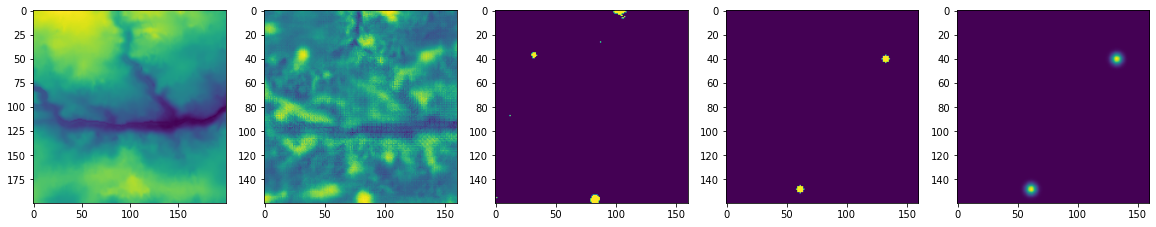

Sadly only 1 images could be outputted.
./3_Peaks_40_Epochs.pt 0.026394946323264213 0.10530894710904076


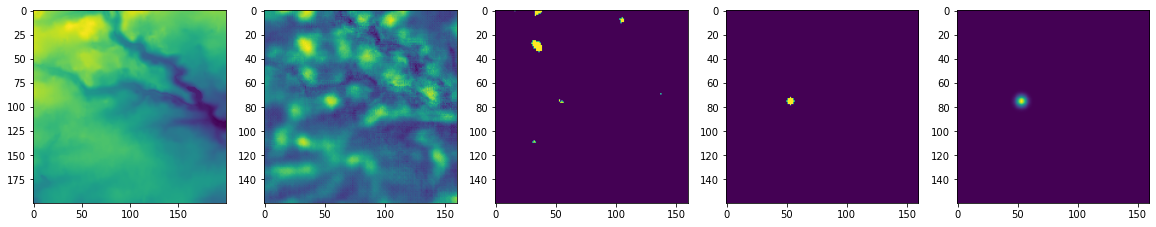

Sadly only 1 images could be outputted.
./onepeak.pt 0.20272073504470645 0.0011676837913090275


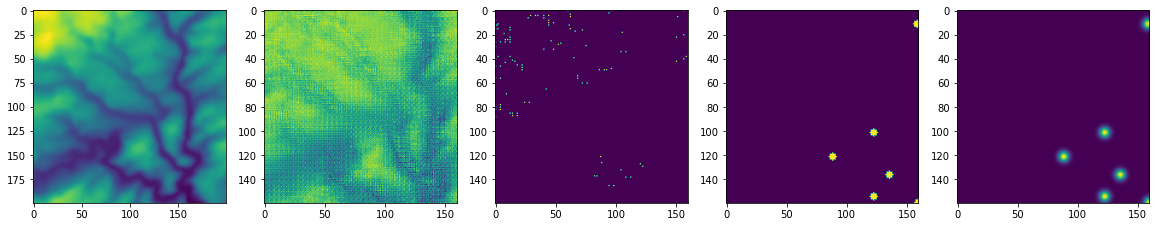

Sadly only 1 images could be outputted.
./onepeak.pt 0.20417023769446782 0.0010159099917572902


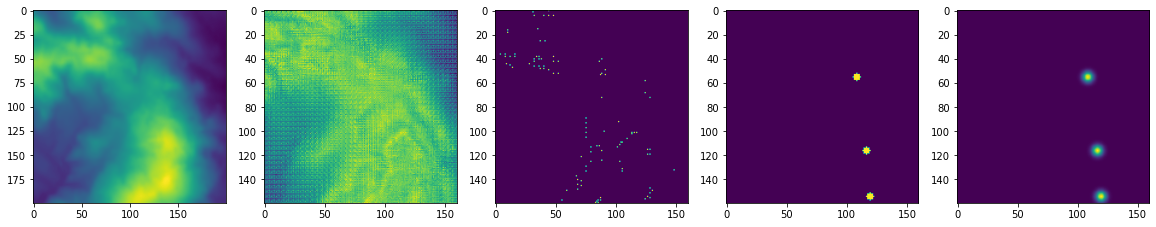

Sadly only 1 images could be outputted.
./onepeak_40_Epochs.pt 0.0747665890625545 0.02219656697181134


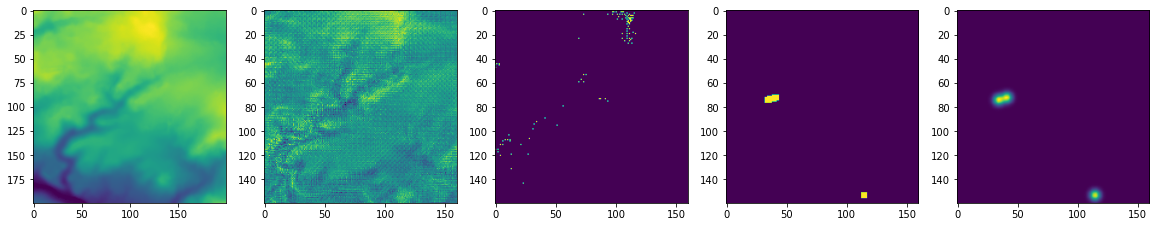

Sadly only 1 images could be outputted.
./3_Peaks_20_Epochs.pt 0.03676393175763743 0.12500352341504323


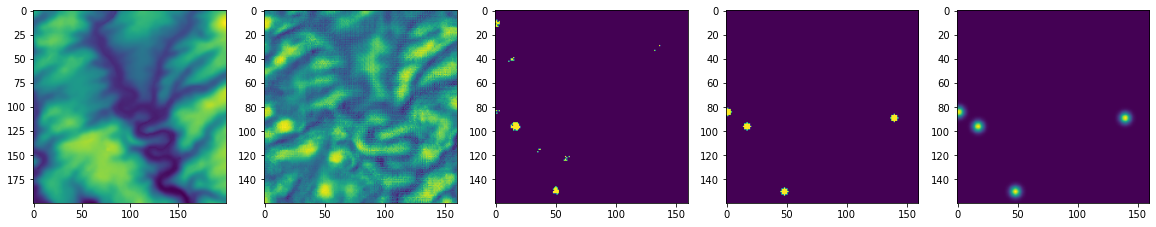

Sadly only 1 images could be outputted.
./3_Peaks_40_Epochs.pt 0.03326215222477913 0.1363374660057681


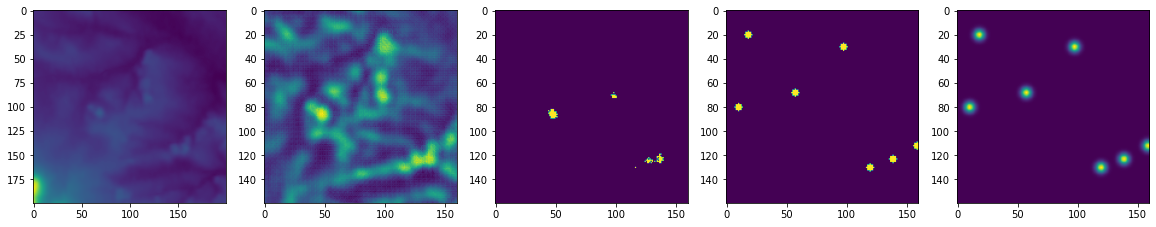

Sadly only 1 images could be outputted.
./onepeak.pt 0.19682530136335463 0.0015858054976882435


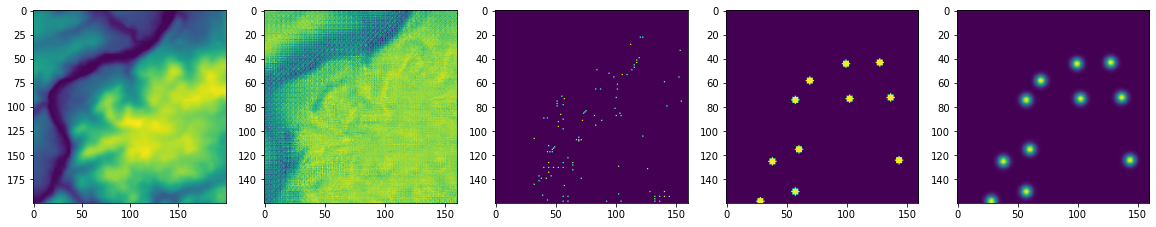

Sadly only 1 images could be outputted.
./onepeak.pt 0.1982799463328861 0.0014013250086847126


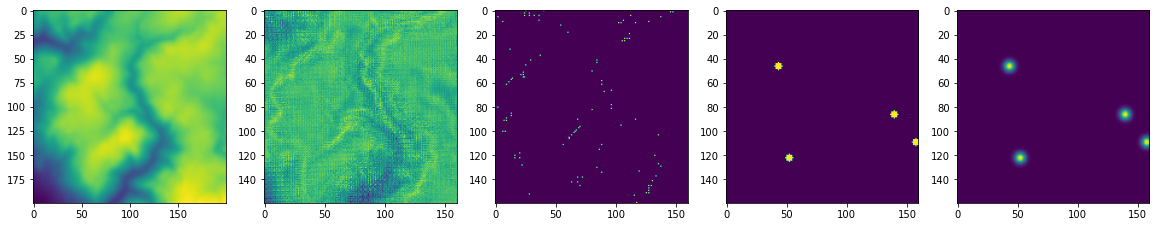

Sadly only 1 images could be outputted.
./onepeak_40_Epochs.pt 0.07981223187276296 0.02637489480236485


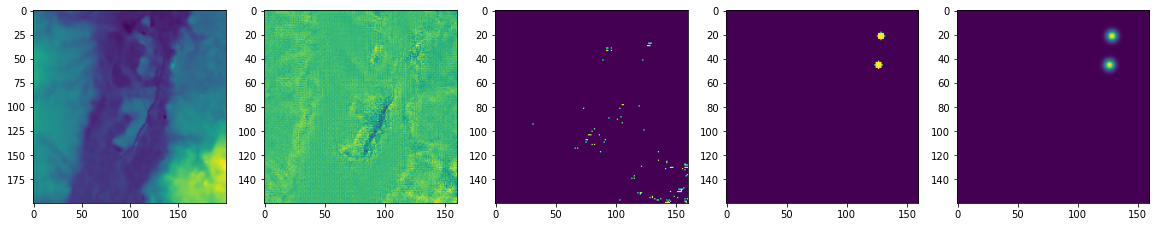

Sadly only 1 images could be outputted.
./3_Peaks_20_Epochs.pt 0.044188588325466426 0.1317733567030657


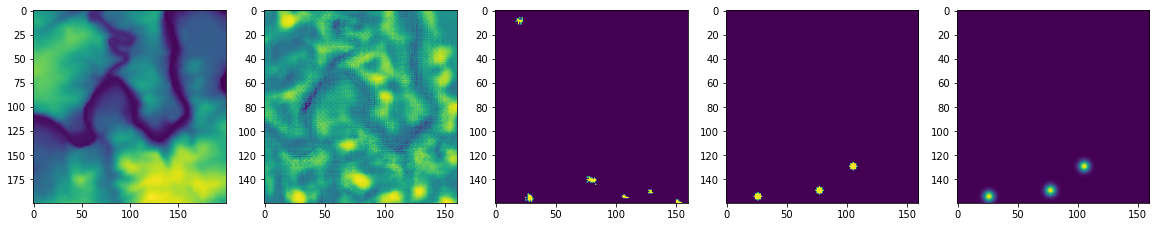

Sadly only 1 images could be outputted.
./3_Peaks_40_Epochs.pt 0.04056508120681558 0.14628580485877204


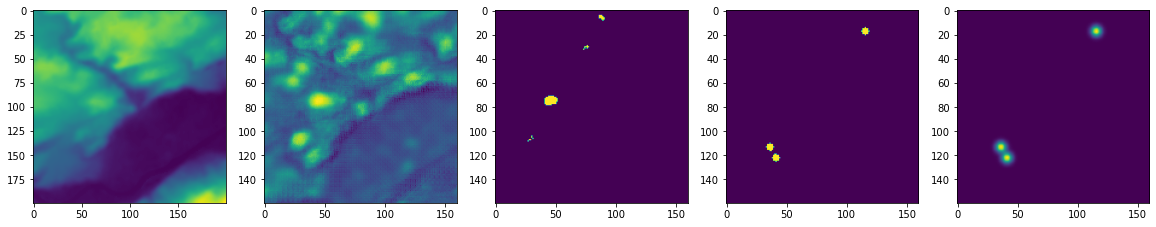

Sadly only 1 images could be outputted.
./onepeak.pt 0.20368645801430657 0.0020860171504046526


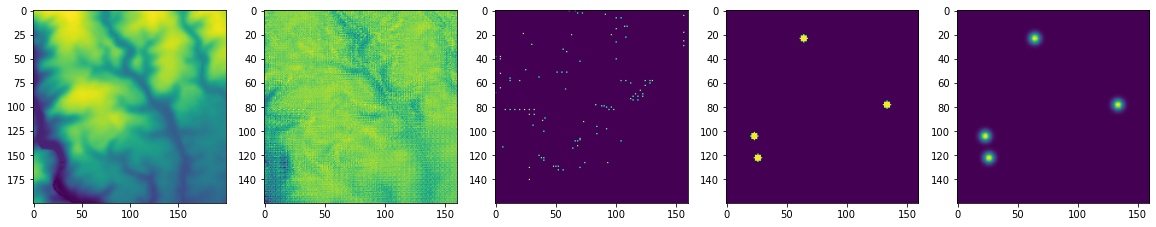

Sadly only 1 images could be outputted.
./onepeak.pt 0.20191502287274316 0.002086017135231858


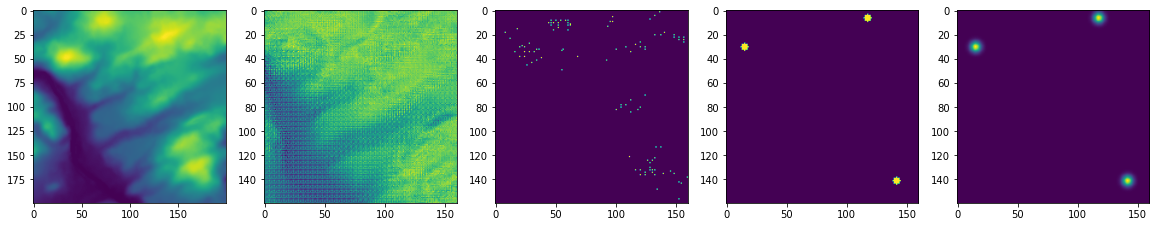

Sadly only 1 images could be outputted.
./onepeak_40_Epochs.pt 0.08656813097851616 0.0326792986930481


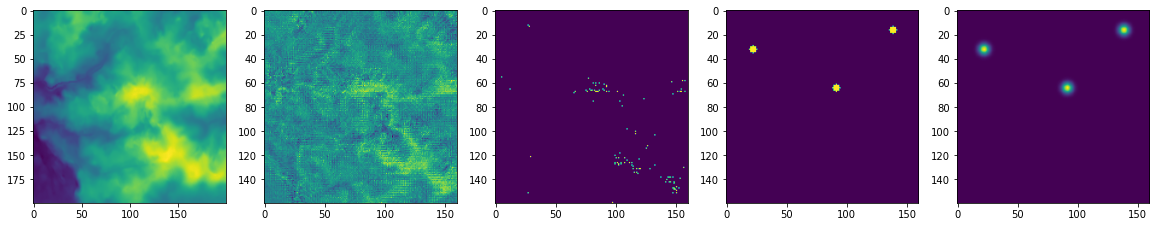

Sadly only 1 images could be outputted.
./3_Peaks_20_Epochs.pt 0.04968134473477091 0.14150411174410865


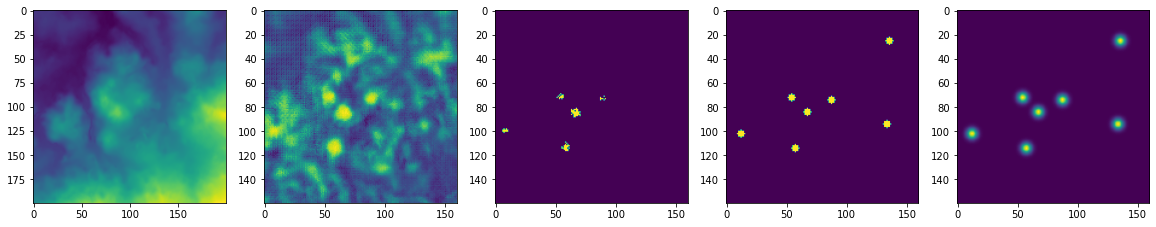

Sadly only 1 images could be outputted.
./3_Peaks_40_Epochs.pt 0.04701904615476018 0.14714031613298825


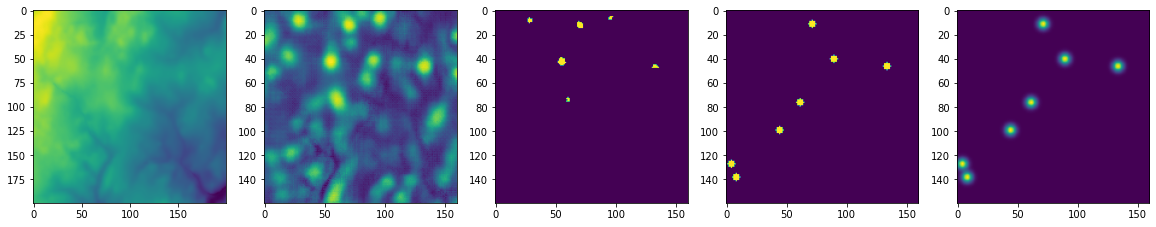

Sadly only 1 images could be outputted.
./onepeak.pt 0.2057652622461319 0.002593239087413194


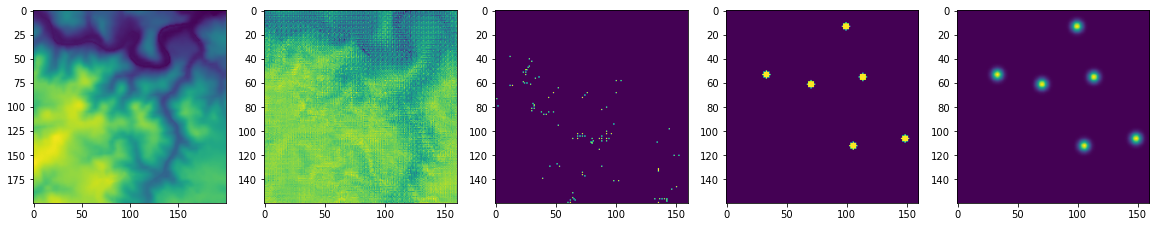

Sadly only 1 images could be outputted.
./onepeak.pt 0.20806882069224403 0.002454710910612038


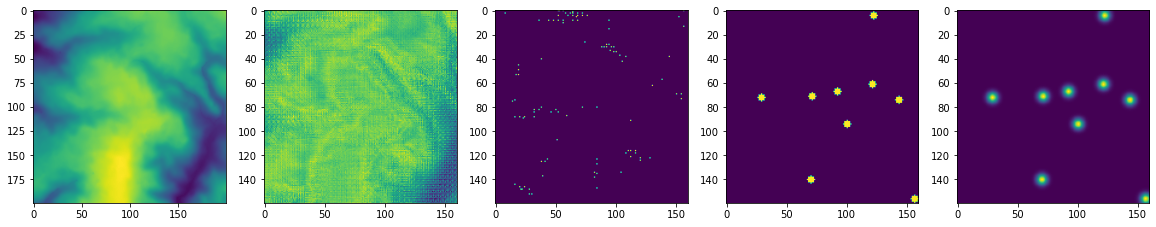

Sadly only 1 images could be outputted.
./onepeak_40_Epochs.pt 0.09201544665154957 0.03844399031783853


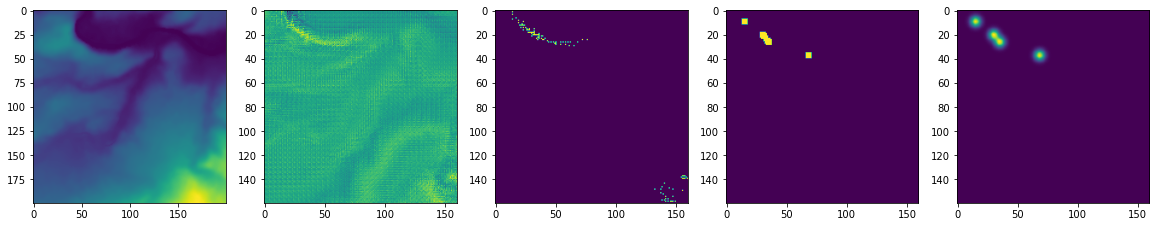

Sadly only 1 images could be outputted.
./3_Peaks_20_Epochs.pt 0.055749688474904927 0.1255491320930776


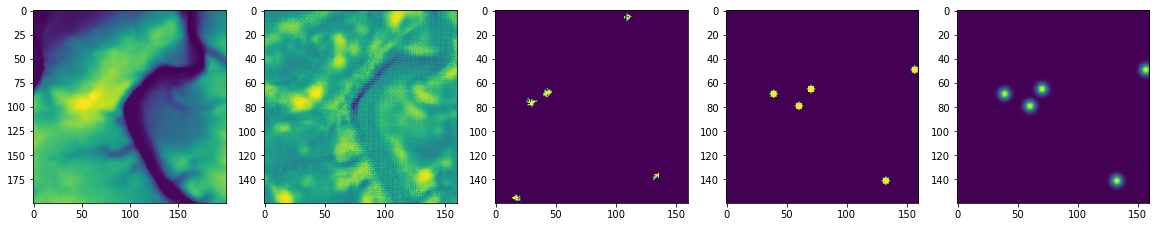

Sadly only 1 images could be outputted.
./3_Peaks_40_Epochs.pt 0.05246226312149139 0.14758316037200747


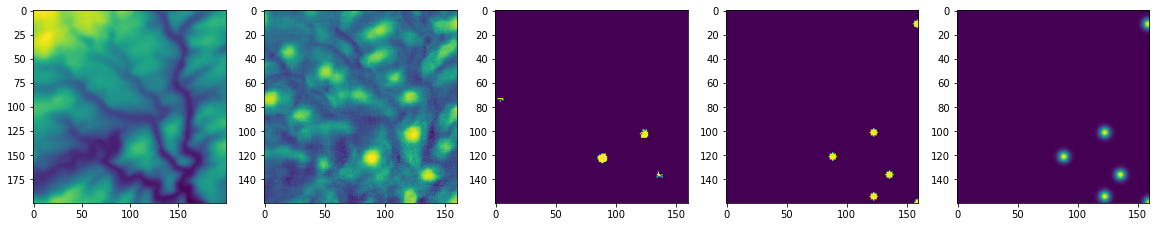

Sadly only 1 images could be outputted.
./onepeak.pt 0.21112601600942157 0.002375722334862342


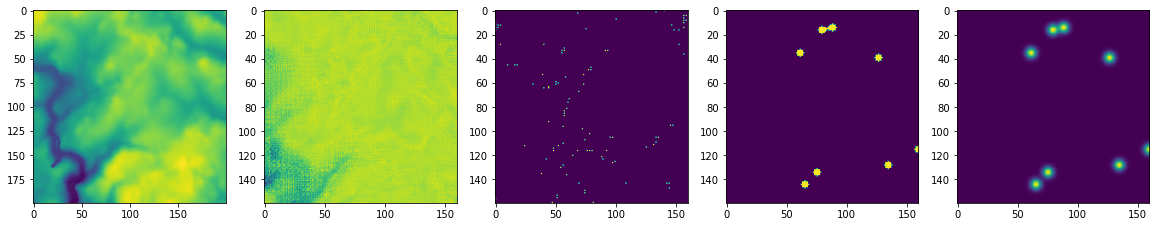

Sadly only 1 images could be outputted.
./onepeak.pt 0.20664777287415095 0.002514250476736474


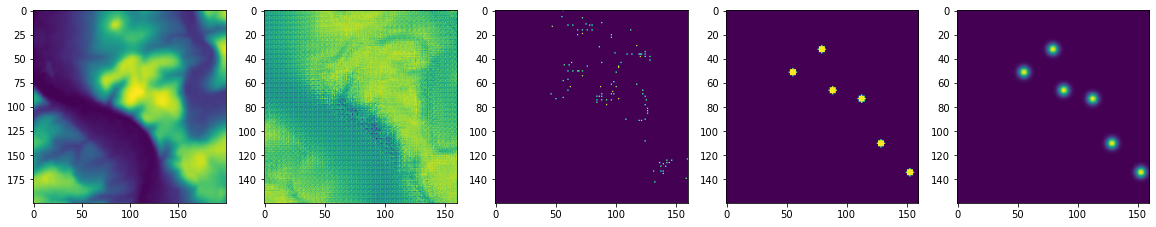

Sadly only 1 images could be outputted.
./onepeak_40_Epochs.pt 0.09810343987884976 0.029312019815899253


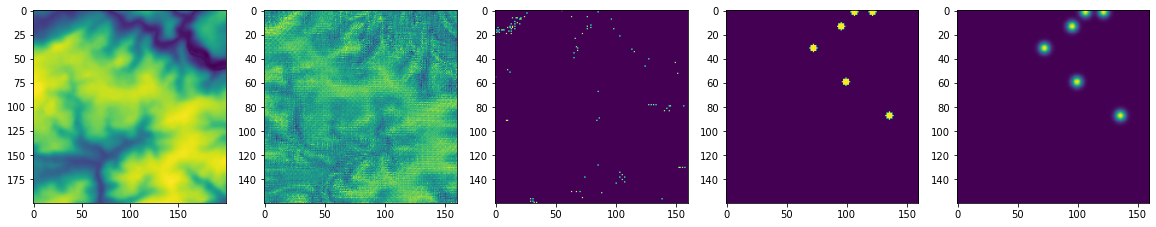

Sadly only 1 images could be outputted.
./3_Peaks_20_Epochs.pt 0.055749688474904927 0.1255491320930776
./3_Peaks_40_Epochs.pt 0.05246226312149139 0.14758316037200747
./onepeak.pt 0.20664777287415095 0.002514250476736474
./onepeak_40_Epochs.pt 0.09810343987884976 0.029312019815899253
./3_Peaks_20_Epochs.pt 0.055749688474904927 0.1255491320930776
./3_Peaks_40_Epochs.pt 0.05246226312149139 0.14758316037200747
./onepeak.pt 0.20664777287415095 0.002514250476736474
./onepeak_40_Epochs.pt 0.09810343987884976 0.029312019815899253
./3_Peaks_20_Epochs.pt 0.055749688474904927 0.1255491320930776
./3_Peaks_40_Epochs.pt 0.05246226312149139 0.14758316037200747
./onepeak.pt 0.20664777287415095 0.002514250476736474
./onepeak_40_Epochs.pt 0.09810343987884976 0.029312019815899253
./3_Peaks_20_Epochs.pt 0.055749688474904927 0.1255491320930776
./3_Peaks_40_Epochs.pt 0.05246226312149139 0.14758316037200747
./onepeak.pt 0.20664777287415095 0.002514250476736474
./onepeak_40_Epochs.pt 0.09810343987884976 0.029

In [193]:
image_path = ["./dataset/", "./dataset_2Peaks/", "./dataset_3Peaks/", "./dataset_4Peaks/", "./dataset_5Peaks/"]
networkPaths = ["./3_Peaks_20_Epochs.pt", "./3_Peaks_40_Epochs.pt", "./onepeak.pt", "./onepeak_40_Epochs.pt"]
networkNames = {"./3_Peaks_20_Epochs.pt":"3 Peaks, 20 Epochs", "./3_Peaks_40_Epochs.pt":"3 Peaks, 40 Epochs",
                "./onepeak.pt":"1 Peak, 20 Epochs", "./onepeak_40_Epochs.pt": "1 Peak, 40 Epochs"}
y = []
for path in image_path:
    models, ys = testNetwork(networkPaths, path, BATCH_SIZE = 5)
    y.append(models)

for i in y:
    for name in models:
        print(name, models[name]["loss"],models[name]["accuracy"])

In [194]:
x = {}
for mname in y[0]:
    name = networkNames[mname]

    x[name] = {}
    for dname in y[0]["./3_Peaks_20_Epochs.pt"]:
        x[name][dname] = []
for n, models in enumerate(y):
    for mname in models:
        model = models[mname]
        name = networkNames[mname]
        for dname in model:
            x[name][dname].append(model[dname])


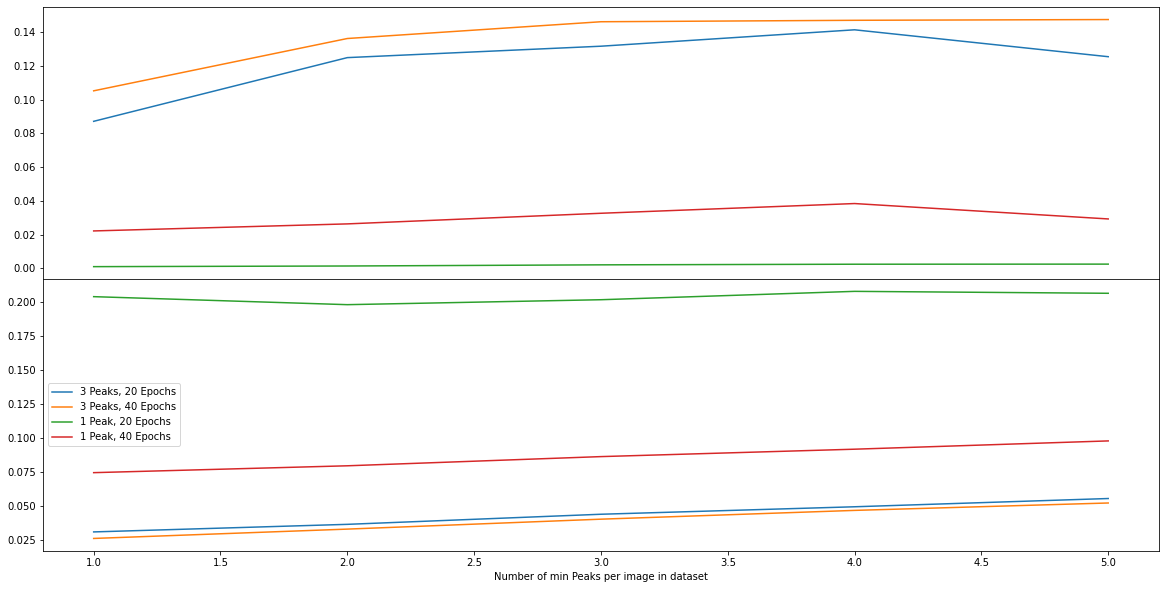

In [195]:

fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(2,1, hspace=0)
accAx, lossAx = gs.subplots()

        
for name in x:
    model = x[name]
    acc = model["accuracy"]
    loss = model["loss"]
    accAx.plot(range(1,6), acc, label = name)
    lossAx.plot(range(1,6), loss, label = name)

plt.xlabel("Number of min Peaks per image in dataset")
plt.legend()

In [ ]:
ungleichheit